OK. There might be something promising here.

We run bic criterion to determine the flag type. Then we use FlagRep, with this flag type, on the PCs. This results in the same representation as svd and qr with respect to the subspace and the flag distances. But, with respect to the Frobenius norm, FlagRep seems to do a little better.

In [ ]:
import numpy as np

import FlagRep as FR

import itertools
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import os
from skimage import color
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d
import torch

from PSA_utils import *

Do PSA to identify flag type, then run flagrep

Flowers

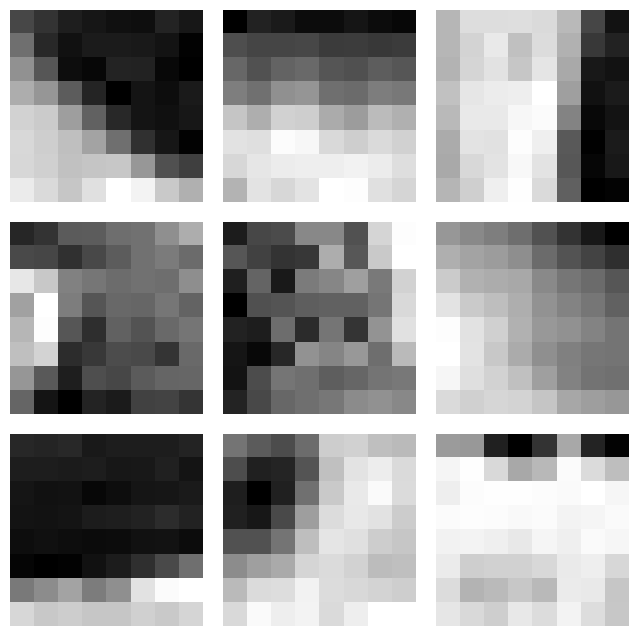

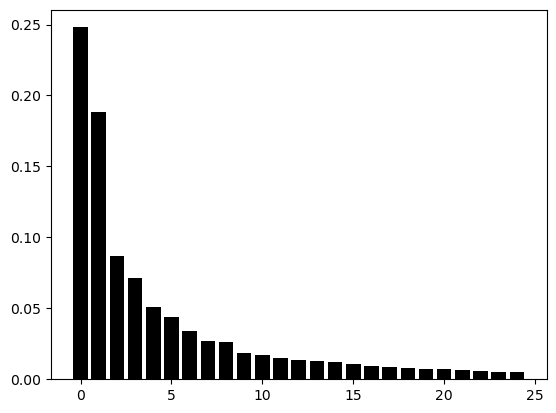

In [65]:
np.random.seed(42)

# Generate dataset
dir_name = "../data/flower_10/"
patchsize = 8
n = 500
X_img = []
for i, file in enumerate(os.listdir(dir_name)):
    img = color.rgb2gray(io.imread(dir_name+file))
    patches = extract_patches_2d(img, (patchsize, patchsize))
    patches = patches - np.mean(patches, axis=(1, 2))[:, np.newaxis, np.newaxis]  # remove DC component
    X_img.append(patches[np.random.choice(np.arange(patches.shape[0]), size=n//10, replace=False)])
X = np.concatenate(X_img, axis=0)

# Plot dataset
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X[n//10 * i], cmap="gray")
    ax.axis('off')
fig.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

# Compute BIC of PPCA and PSA models
X = X.reshape((n, patchsize*patchsize))
n, p = X.shape
eigval, eigvec = evd(X)
plt.figure()
plt.bar(np.arange(25), eigval[:25], color='k')
plt.show()
bic_psa = bic((2, 3, p - 5), eigval, n)
bic_ppca = bic((1, 1, 1, 1, 1, p - 5), eigval, n)


In [66]:
n_pcs = 5

models = [[1,1,1,1,1,p-n_pcs],
        [1,1,1,2,p-n_pcs],[1,1,2,1,p-n_pcs],[1,2,1,1,p-n_pcs],[2,1,1,1,p-n_pcs],
        [3,1,1,p-n_pcs],[2,2,1,p-n_pcs],[1,3,1,p-n_pcs],[2,1,2,p-n_pcs],[1,2,2,p-n_pcs],[1,1,3,p-n_pcs],
        [4,1,p-n_pcs],[3,2,p-n_pcs],[2,3,p-n_pcs],[1,4,p-n_pcs],
        [5,p-n_pcs]]


best_model, best_bic = model_selection(X, models, criterion="bic")

In [67]:
mu = np.mean(X, axis=0)
X_centered = X - mu
pcs = X_centered @ eigvec[:,:n_pcs]

In [68]:
fl_type = np.cumsum(best_model[:-1])

In [69]:
# the feature hierarchy 

Aset = [np.arange(ssd) for ssd in fl_type]

frep, _ = FR.FlagRep(pcs, Aset)
u,_,_ = np.linalg.svd(pcs, full_matrices=False)
q,_ = np.linalg.qr(pcs)

In [70]:
print('Euclidean distance')
print(np.linalg.norm(frep- pcs)/np.linalg.norm(frep))
print(np.linalg.norm(u- pcs)/np.linalg.norm(frep))
print(np.linalg.norm(q- pcs)/np.linalg.norm(frep))

print('Projection distance (subspace)')
print(np.sqrt(2)*np.linalg.norm(frep @frep.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(u @ u.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(q @ q.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))

print('Projection distance (flag)')

frep_dist = np.sqrt(2)*np.linalg.norm(frep[:,:fl_type[0]] @frep[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
svd_dist = np.sqrt(2)*np.linalg.norm(u[:,:fl_type[0]] @ u[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
qr_dist = np.sqrt(2)*np.linalg.norm(q[:,:fl_type[0]] @ q[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
for i in range(len(fl_type)-1):
    frep_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    svd_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    qr_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)

print(frep_dist)
print(svd_dist)
print(qr_dist)

Euclidean distance
7.992719052096974
8.177002032240155
8.31647931952031
Projection distance (subspace)
3.036543675781603e-15
3.98256114041755e-15
2.741617789104461e-15
Projection distance (flag)
5.652482055072146e-15
7.013973410837866e-15
5.652482055072146e-15


Cats and dogs

In [71]:
n_pcs = 5

data = torch.load('../data/cats_dogs/myCATS.pt').numpy().T
p, n_feats = data.shape


models = [[1,1,1,1,1,n_feats-n_pcs],
        [1,1,1,2,n_feats-n_pcs],[1,1,2,1,n_feats-n_pcs],[1,2,1,1,n_feats-n_pcs],[2,1,1,1,n_feats-n_pcs],
        [3,1,1,n_feats-n_pcs],[2,2,1,n_feats-n_pcs],[1,3,1,n_feats-n_pcs],[2,1,2,n_feats-n_pcs],[1,2,2,n_feats-n_pcs],[1,1,3,n_feats-n_pcs],
        [4,1,n_feats-n_pcs],[3,2,n_feats-n_pcs],[2,3,n_feats-n_pcs],[1,4,n_feats-n_pcs],
        [5,n_feats-n_pcs]]

#regular PCA
eigval, eigvec = evd(data)
baseline_weights = eigvec[:,:n_pcs]
true_fl_type, _ = model_selection_eval(data, eigval, models, criterion="bic")
fl_type = list(np.cumsum(true_fl_type)[:-1])

/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_44857/2189361400.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('../data/cats_dogs/myCATS.p

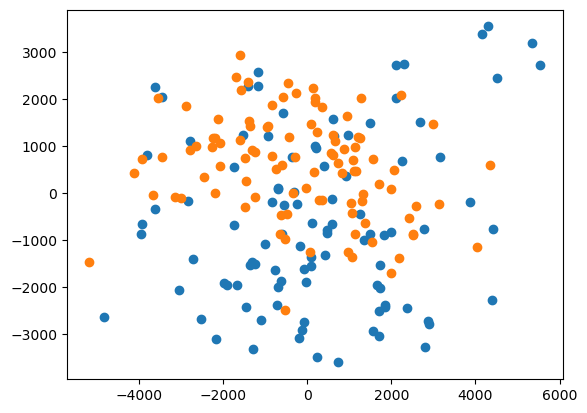

In [72]:
mu = np.mean(data, axis=0)
X_centered = data - mu
pcs = X_centered @ baseline_weights

plt.scatter(pcs[:99,0],pcs[:99,1])
plt.scatter(pcs[99:,0],pcs[99:,1])

In [73]:
Aset = [np.arange(ssd) for ssd in fl_type]

frep, _ = FR.FlagRep(pcs, Aset)
u,_,_ = np.linalg.svd(pcs, full_matrices=False)
q,_ = np.linalg.qr(pcs)

In [74]:
print('Relative Euclidean distance')
print(np.linalg.norm(frep- pcs)/np.linalg.norm(pcs))
print(np.linalg.norm(u- pcs)/np.linalg.norm(pcs))
print(np.linalg.norm(q- pcs)/np.linalg.norm(pcs))

print('Projection distance (subspace)')
print(np.sqrt(2)*np.linalg.norm(frep @frep.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(u @ u.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(q @ q.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))

print('Projection distance (flag)')

frep_dist = np.sqrt(2)*np.linalg.norm(frep[:,:fl_type[0]] @frep[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
svd_dist = np.sqrt(2)*np.linalg.norm(u[:,:fl_type[0]] @ u[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
qr_dist = np.sqrt(2)*np.linalg.norm(q[:,:fl_type[0]] @ q[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
for i in range(len(fl_type)-1):
    frep_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    svd_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    qr_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)

print(frep_dist)
print(svd_dist)
print(qr_dist)

Relative Euclidean distance
0.9999653859305656
0.9999653859305656
0.9999920584090137
Projection distance (subspace)
2.6041520258733936e-15
2.466566420676445e-15
2.602802426981864e-15
Projection distance (flag)
7.655856307553561e-15
7.655856307553561e-15
7.655856307553561e-15


digits from https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits

In [12]:

from sklearn import datasets

In [13]:
mnist_dset = datasets.load_digits(n_class=2)

In [14]:
X = mnist_dset['data']
labels = mnist_dset['target']

In [15]:
_,n_feats = X.shape

In [16]:
n_pcs = 5

models = [[1,1,1,1,1,n_feats-n_pcs],
        [1,1,1,2,n_feats-n_pcs],[1,1,2,1,n_feats-n_pcs],[1,2,1,1,n_feats-n_pcs],[2,1,1,1,n_feats-n_pcs],
        [3,1,1,n_feats-n_pcs],[2,2,1,n_feats-n_pcs],[1,3,1,n_feats-n_pcs],[2,1,2,n_feats-n_pcs],[1,2,2,n_feats-n_pcs],[1,1,3,n_feats-n_pcs],
        [4,1,n_feats-n_pcs],[3,2,n_feats-n_pcs],[2,3,n_feats-n_pcs],[1,4,n_feats-n_pcs],
        [5,n_feats-n_pcs]]

#regular PCA
eigval, eigvec = evd(X)
baseline_weights = eigvec[:,:n_pcs]
true_fl_type, _ = model_selection_eval(X, eigval, models, criterion="bic")
fl_type = list(np.cumsum(true_fl_type)[:-1])

In [17]:
mu = np.mean(X, axis=0)
X_centered = X - mu
pcs = X_centered @ baseline_weights

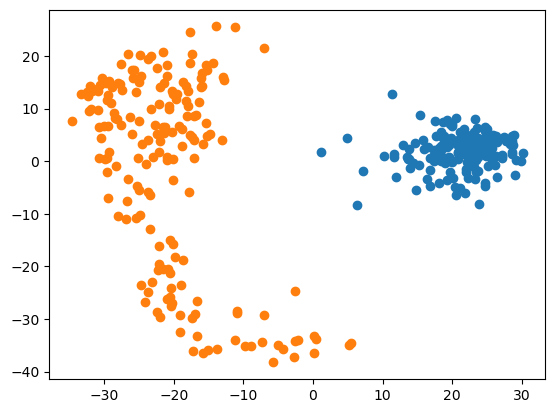

In [18]:
plt.scatter(pcs[np.where(labels == 0),0],pcs[np.where(labels == 0),1])
plt.scatter(pcs[np.where(labels == 1),0],pcs[np.where(labels == 1),1])

In [19]:
Aset = [np.arange(ssd) for ssd in fl_type]

frep, _ = FR.FlagRep(pcs, Aset)
u,_,_ = np.linalg.svd(pcs, full_matrices=False)
q,_ = np.linalg.qr(pcs)

In [20]:
print('Relative Euclidean distance')
print(np.linalg.norm(frep- pcs)/np.linalg.norm(pcs))
print(np.linalg.norm(u- pcs)/np.linalg.norm(pcs))
print(np.linalg.norm(q- pcs)/np.linalg.norm(pcs))

print('Projection distance (subspace)')
print(np.sqrt(2)*np.linalg.norm(frep @frep.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(u @ u.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(q @ q.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))

print('Projection distance (flag)')

frep_dist = np.sqrt(2)*np.linalg.norm(frep[:,:fl_type[0]] @frep[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
svd_dist = np.sqrt(2)*np.linalg.norm(u[:,:fl_type[0]] @ u[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
qr_dist = np.sqrt(2)*np.linalg.norm(q[:,:fl_type[0]] @ q[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
for i in range(len(fl_type)-1):
    frep_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    svd_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    qr_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)

print(frep_dist)
print(svd_dist)
print(qr_dist)

Relative Euclidean distance
0.9980284493235272
0.9998267322047474
1.001485067812539
Projection distance (subspace)
3.101390779301686e-15
1.745564824796981e-15
1.7036230063306392e-15
Projection distance (flag)
3.9473930306682905e-15
3.9473930306682905e-15
3.9473930306682905e-15


In [21]:
baseline_weights

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.14777804e-04,  6.81758142e-04, -7.38094832e-05,
         1.43815869e-04, -1.57340085e-04],
       [ 4.56278875e-02,  1.03432172e-01,  8.25138997e-02,
        -7.53545592e-02, -2.57925414e-01],
       [ 6.57518868e-02,  2.99053101e-01, -4.57303635e-03,
        -4.07545261e-02,  2.36213385e-02],
       [ 9.89609415e-03, -1.42471388e-02, -2.54646636e-01,
         1.41277441e-01, -6.20674803e-02],
       [-4.33411772e-02, -2.59635919e-01, -1.30667708e-01,
         3.19588763e-02, -2.31303739e-01],
       [-1.31238148e-02, -6.50628122e-02, -1.88616100e-02,
        -1.73749862e-02, -1.09253337e-02],
       [ 0.00000000e+00,  0.00000000e+00, -1.11022302e-16,
        -1.38777878e-16,  1.45716772e-16],
       [ 4.23516474e-22,  0.00000000e+00,  0.00000000e+00,
         1.11022302e-16, -3.46944695e-16],
       [ 1.99878605e-02,  6.73516779e-03,  5.61748680e-03,
         1.11996387e-02